# **Pengambilan Data C-MET dari Chembl**


# **01 - Prep Environtment**

## Instalasi

In [1]:
! pip install chembl_webresource_client
! pip install lazypredict
! pip install jcopml==1.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.1.1-py2.py3-none-any.whl size=27509 sha256=5b4907c61af78116b81a85a6b698ec7585ad4420dade0f3dd4e7d6bb3863bcb2
  Stored in directory: /root/.cache/pip/wheels/79/3f/d2/72357060b29488def73bceb49f653ca88a60a3ddac63cf7780
Successfully built jcopml


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 37.5 MB/s eta 0:00:00


In [3]:
!pip install --upgrade scikit-learn==0.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (scikit-learn)


In [4]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client


## Import

In [5]:


import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Descriptors, Lipinski

import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier

from tqdm import tqdm

#from jcopml.pipeline import num_pipe, cat_pipe
#from jcopml.utils import save_model, load_model
#from jcopml.plot import plot_missing_value
#from jcopml.feature_importance import mean_score_decrease

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Pencarian Database Berdasarkan Kata Kunci Reseptor/Target

In [6]:
target = new_client.target
target_query = target.search('c-Met')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P08581', 'xref_name': None, 'xre...",Homo sapiens,Hepatocyte growth factor receptor,22.00,False,CHEMBL3717,"[{'accession': 'P08581', 'component_descriptio...",SINGLE PROTEIN,9606.00
1,"[{'xref_id': 'P16056', 'xref_name': None, 'xre...",Mus musculus,Hepatocyte growth factor receptor,22.00,False,CHEMBL5585,"[{'accession': 'P16056', 'component_descriptio...",SINGLE PROTEIN,10090.00
2,[],Canis familiaris,Hepatocyte growth factor receptor,22.00,False,CHEMBL2046265,"[{'accession': 'Q75ZY9', 'component_descriptio...",SINGLE PROTEIN,9615.00
3,[],Escherichia coli,Met repressor,19.00,False,CHEMBL1938227,"[{'accession': 'C3SIU2', 'component_descriptio...",SINGLE PROTEIN,562.00
4,[],Mus musculus,TPR/MET fusion protein,19.00,False,CHEMBL3038516,"[{'accession': 'P16056', 'component_descriptio...",CHIMERIC PROTEIN,10090.00
...,...,...,...,...,...,...,...,...,...
851,[],Drosophila melanogaster,Nicotinic acetylcholine receptor,0.00,False,CHEMBL3350223,"[{'accession': 'P25162', 'component_descriptio...",PROTEIN COMPLEX GROUP,7227.00
852,[],Escherichia coli,1-deoxy-D-xylulose 5-phosphate reductoisomerase,0.00,False,CHEMBL3421521,"[{'accession': 'W8T2T2', 'component_descriptio...",SINGLE PROTEIN,562.00
853,[],Homo sapiens,UDP-glucuronosyltransferases (UGTs),0.00,False,CHEMBL4523985,"[{'accession': 'P22310', 'component_descriptio...",PROTEIN FAMILY,9606.00
854,[],Homo sapiens,Cytochrome P450,0.00,False,CHEMBL4523986,"[{'accession': 'P08684', 'component_descriptio...",PROTEIN FAMILY,9606.00


## Filter berdasarkan HomoSapiens

In [7]:
def targetFilter(x):
    selected_target = targets.target_chembl_id[x]
    activity = new_client.activity
    res = activity.filter(target_chembl_id=selected_target).filter(organism="Homo sapiens")
    df = pd.DataFrame.from_dict(res)
    return df

In [8]:
df_1 = targetFilter(0)
df_2 = targetFilter(1)
df_3 = targetFilter(2)

## Menggabungkan semua data menjadi satu dataframe

In [9]:
df = pd.concat([df_1, df_2, df_3], ignore_index = True)

In [10]:
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,572163,[],CHEMBL769150,Inhibition of Protein kinase Met at 10 uM,B,None,None,BAO_0000201,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,Inhibition,%,UO_0000187,None,40.0
1,None,None,653063,[],CHEMBL820578,Inhibition of c-Met autophosphorylation of in ...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,nM,UO_0000065,None,10000.0
2,None,Not Active,653066,[],CHEMBL820422,Inhibition of c-Met autophosphorylation in int...,B,None,None,BAO_0000375,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,Activity,None,None,None,None
3,None,None,750649,[],CHEMBL880758,Inhibition of MET kinase activity,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,nM,UO_0000065,None,10000.0
4,None,None,1068014,[],CHEMBL711149,Inhibition of Met proto-oncogene tyrosine kinase,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10782,None,Active,13499535,[],CHEMBL2446868,Inhibition of c-Met in MDCK cells assessed as ...,B,None,None,BAO_0000201,...,Canis familiaris,Hepatocyte growth factor receptor,9615,None,None,INH,None,UO_0000187,None,None
10783,None,Active,13499536,[],CHEMBL2446869,Inhibition of c-Met in MDCK cells assessed as ...,B,None,None,BAO_0000201,...,Canis familiaris,Hepatocyte growth factor receptor,9615,None,None,INH,None,UO_0000187,None,None
10784,None,Dose-dependent effect,13499537,[],CHEMBL2446870,Inhibition of c-Met in MDCK cells assessed as ...,B,None,None,BAO_0000201,...,Canis familiaris,Hepatocyte growth factor receptor,9615,None,None,INH,None,UO_0000187,None,None
10785,None,Active,16574743,[],CHEMBL3804088,Inhibition of c-Met in MDCK cells assessed as ...,B,None,None,BAO_0000201,...,Canis familiaris,Hepatocyte growth factor receptor,9615,None,None,INH,None,UO_0000187,None,None


In [11]:
homo_sapiens_df = df[df['target_organism'] == 'Homo sapiens']
homo_sapiens_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,572163,[],CHEMBL769150,Inhibition of Protein kinase Met at 10 uM,B,None,None,BAO_0000201,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,Inhibition,%,UO_0000187,None,40.0
1,None,None,653063,[],CHEMBL820578,Inhibition of c-Met autophosphorylation of in ...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,nM,UO_0000065,None,10000.0
2,None,Not Active,653066,[],CHEMBL820422,Inhibition of c-Met autophosphorylation in int...,B,None,None,BAO_0000375,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,Activity,None,None,None,None
3,None,None,750649,[],CHEMBL880758,Inhibition of MET kinase activity,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,nM,UO_0000065,None,10000.0
4,None,None,1068014,[],CHEMBL711149,Inhibition of Met proto-oncogene tyrosine kinase,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10713,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107011,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263739,Inhibition of c-Met (unknown origin) kinase ac...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,4.31
10714,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107015,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263743,Inhibition of His6-tagged recombinant human c-...,B,None,None,BAO_0000201,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,INH,%,UO_0000187,None,56.0
10715,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107024,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263748,Inhibition of His6-tagged recombinant human c-...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,0.56
10716,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107025,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263749,Inhibition of c-Met (unknown origin) phosphory...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,4.8


In [12]:
dfIC50 = homo_sapiens_df[homo_sapiens_df['standard_type'] == 'IC50']
dfIC50

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
1,None,None,653063,[],CHEMBL820578,Inhibition of c-Met autophosphorylation of in ...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,nM,UO_0000065,None,10000.0
3,None,None,750649,[],CHEMBL880758,Inhibition of MET kinase activity,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,nM,UO_0000065,None,10000.0
4,None,None,1068014,[],CHEMBL711149,Inhibition of Met proto-oncogene tyrosine kinase,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,10.0
5,None,None,1070529,[],CHEMBL711149,Inhibition of Met proto-oncogene tyrosine kinase,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,10.0
6,None,None,1173958,[],CHEMBL697832,Inhibition of Hepatocyte growth factor receptor,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10711,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107000,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263729,Inhibition of human c-Met using poly tyrosine ...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,0.08
10712,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107001,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263729,Inhibition of human c-Met using poly tyrosine ...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,0.05
10713,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107011,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263739,Inhibition of c-Met (unknown origin) kinase ac...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,4.31
10715,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107024,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263748,Inhibition of His6-tagged recombinant human c-...,B,None,None,BAO_0000190,...,Homo sapiens,Hepatocyte growth factor receptor,9606,None,None,IC50,uM,UO_0000065,None,0.56


## Menghapus data yang hilang dan duplikat

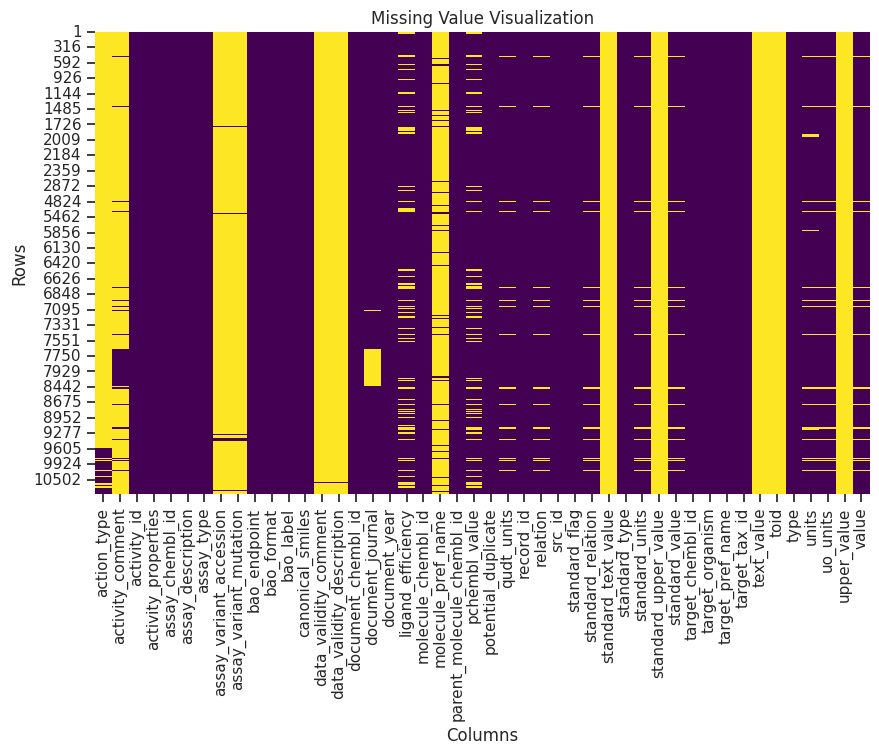

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(dfIC50.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Visualization')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

## Menyeleksi hanya 3 kolom

In [14]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df_prep = dfIC50[selection]

In [15]:
df_prep

,molecule_chembl_id,canonical_smiles,standard_value
1,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,10000.0
3,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,10000.0
4,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,10000.0
5,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,10000.0
6,CHEMBL281957,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,100000.0
...,...,...,...
10711,CHEMBL5287277,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC,80.0
10712,CHEMBL5280503,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...,50.0
10713,CHEMBL5274483,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1,4310.0
10715,CHEMBL5280248,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1,560.0


In [16]:
df_prep = df_prep.dropna()
df_prep

,molecule_chembl_id,canonical_smiles,standard_value
1,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,10000.0
3,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,10000.0
4,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,10000.0
5,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,10000.0
6,CHEMBL281957,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,100000.0
...,...,...,...
10711,CHEMBL5287277,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC,80.0
10712,CHEMBL5280503,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...,50.0
10713,CHEMBL5274483,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1,4310.0
10715,CHEMBL5280248,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1,560.0


## Memberi label pada data

In [17]:
df_prep_label = df_prep

In [18]:
bioactivity_threshold = []
for i in df_prep_label['standard_value']:
    if float(i) >= 10000:
        bioactivity_threshold.append("inactive")
    elif float(i) <= 1000:
        bioactivity_threshold.append("active")
    else:
        bioactivity_threshold.append("intermediate")

In [19]:
df_prep_label

,molecule_chembl_id,canonical_smiles,standard_value
1,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,10000.0
3,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,10000.0
4,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,10000.0
5,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,10000.0
6,CHEMBL281957,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,100000.0
...,...,...,...
10711,CHEMBL5287277,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC,80.0
10712,CHEMBL5280503,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...,50.0
10713,CHEMBL5274483,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1,4310.0
10715,CHEMBL5280248,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1,560.0


In [20]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')

In [21]:
bioactivity_class = pd.DataFrame(bioactivity_class)
bioactivity_class

,class
0,inactive
1,inactive
2,inactive
3,inactive
4,inactive
...,...
5059,active
5060,active
5061,intermediate
5062,active


In [22]:
df_label = pd.concat([df_prep_label.reset_index(drop=True),
                      bioactivity_class.reset_index(drop=True)],
                     axis=1)


In [23]:
df_label

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,10000.0,inactive
1,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,10000.0,inactive
2,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,10000.0,inactive
3,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,10000.0,inactive
4,CHEMBL281957,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,100000.0,inactive
...,...,...,...,...
5059,CHEMBL5287277,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC,80.0,active
5060,CHEMBL5280503,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...,50.0,active
5061,CHEMBL5274483,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1,4310.0,intermediate
5062,CHEMBL5280248,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1,560.0,active


## Transform SMILES menjadi LIST

In [24]:
df_no_smiles = df_label.drop(columns='canonical_smiles')
df_no_smiles

,molecule_chembl_id,standard_value,class
0,CHEMBL352308,10000.0,inactive
1,CHEMBL115220,10000.0,inactive
2,CHEMBL101683,10000.0,inactive
3,CHEMBL101253,10000.0,inactive
4,CHEMBL281957,100000.0,inactive
...,...,...,...
5059,CHEMBL5287277,80.0,active
5060,CHEMBL5280503,50.0,active
5061,CHEMBL5274483,4310.0,intermediate
5062,CHEMBL5280248,560.0,active


In [25]:
smiles = []

for i in df_label['canonical_smiles']:
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key = len)
    smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [26]:
# prompt: gabungnkan smiles dengan df_no_smiles dan buang kolom NaN

df_combined = pd.concat([smiles, df_no_smiles], axis=1)
df_combined = df_combined.dropna()

In [27]:
#plot_missing_value(df_clean_smiles)

## Menghitung Lipinski Deskriptor

In [28]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [29]:
df_lipinski = lipinski(smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,501.63,6.04,3.00,7.00
1,291.35,3.62,2.00,2.00
2,337.81,4.60,2.00,3.00
3,346.82,5.01,1.00,4.00
4,484.43,6.54,2.00,6.00
...,...,...,...,...
5059,419.41,4.83,1.00,6.00
5060,621.67,6.41,2.00,8.00
5061,387.45,2.23,2.00,8.00
5062,338.49,6.32,0.00,2.00


## Menggabungkan antara dataset dengan deskriptor lipinski

In [30]:
df_combined = pd.concat([df_no_smiles,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL352308,10000.0,inactive,501.63,6.04,3.00,7.00
1,CHEMBL115220,10000.0,inactive,291.35,3.62,2.00,2.00
2,CHEMBL101683,10000.0,inactive,337.81,4.60,2.00,3.00
3,CHEMBL101253,10000.0,inactive,346.82,5.01,1.00,4.00
4,CHEMBL281957,100000.0,inactive,484.43,6.54,2.00,6.00
...,...,...,...,...,...,...,...
5059,CHEMBL5287277,80.0,active,419.41,4.83,1.00,6.00
5060,CHEMBL5280503,50.0,active,621.67,6.41,2.00,8.00
5061,CHEMBL5274483,4310.0,intermediate,387.45,2.23,2.00,8.00
5062,CHEMBL5280248,560.0,active,338.49,6.32,0.00,2.00


## Konversi IC50 menjadi pIC50

In [31]:
import pandas as pd
import numpy as np

# Fungsi untuk menghitung pIC50
def pIC50(input):
    # Membuat list untuk pIC50
    pIC50 = []

    # Mengonversi nilai standard_value ke pIC50
    for i in input['standard_value']:
        if pd.isna(i):  # Menangani nilai NaN
            pIC50.append(np.nan)
        else:
            molar = i * (10**-9)  # Mengonversi nM ke M
            pIC50.append(-np.log10(molar))  # Menghitung pIC50

    # Menambahkan kolom pIC50 ke DataFrame
    input['pIC50'] = pIC50

    # Menghapus kolom 'standard_value' jika tidak dibutuhkan
    input = input.drop('standard_value', axis='columns')

    return input

# Fungsi untuk normalisasi nilai pada 'standard_value'
def norm_value(input):
    # Pastikan kolom 'standard_value' sudah numerik
    input['standard_value'] = pd.to_numeric(input['standard_value'], errors='coerce')

    # List untuk nilai yang sudah dinormalisasi
    norm = []

    # Menormalkan nilai 'standard_value'
    for i in input['standard_value']:
        if pd.isna(i):  # Menangani NaN jika ada
            norm.append(np.nan)
        else:
            if i > 100000000:  # Pembatasan nilai lebih besar dari 100000000
                i = 100000000
            norm.append(i)

    # Menyimpan nilai yang telah dinormalisasi pada kolom 'standard_value'
    input['standard_value'] = norm

    return input

In [32]:
df_combined = norm_value(df_combined)  # Normalisasi kolom 'standard_value'
df_combined = pIC50(df_combined)  # Hitung pIC50 dan hapus kolom 'standard_value'


In [33]:
df_combined = pd.concat([df_combined,pd.DataFrame(smiles)], axis=1)

In [34]:
df_combined

,molecule_chembl_id,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,canonical_smiles
0,CHEMBL352308,inactive,501.63,6.04,3.00,7.00,5.00,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...
1,CHEMBL115220,inactive,291.35,3.62,2.00,2.00,5.00,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1
2,CHEMBL101683,inactive,337.81,4.60,2.00,3.00,5.00,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1
3,CHEMBL101253,inactive,346.82,5.01,1.00,4.00,5.00,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
4,CHEMBL281957,inactive,484.43,6.54,2.00,6.00,4.00,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...
...,...,...,...,...,...,...,...,...
5059,CHEMBL5287277,active,419.41,4.83,1.00,6.00,7.10,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC
5060,CHEMBL5280503,active,621.67,6.41,2.00,8.00,7.30,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...
5061,CHEMBL5274483,intermediate,387.45,2.23,2.00,8.00,5.37,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1
5062,CHEMBL5280248,active,338.49,6.32,0.00,2.00,6.25,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1


## Menghapus kelas 'intermediet class'

In [ ]:
#df_2class = df_final[df_final['class'] != 'intermediate']
#df_2class

In [ ]:
#df_2class.isna().sum()

In [ ]:
#df_2class.to_csv('01_label2class_sars.csv', index=False)

## PLOTTING

### Plot frekuensi dari dua kelas bioaktifitas

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot MW vs LogP

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### pIC50 Value Boxplots

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

### **Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

### MW

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

### LogP

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

### NumHDonors

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

### NumHAcceptors

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

# **04 - Fingerprint Generation**

## Padel Descriptor

In [35]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df_combined[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [36]:
df_selection

,canonical_smiles,molecule_chembl_id
0,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,CHEMBL352308
1,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,CHEMBL115220
2,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,CHEMBL101683
3,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,CHEMBL101253
4,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,CHEMBL281957
...,...,...
5059,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC,CHEMBL5287277
5060,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...,CHEMBL5280503
5061,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1,CHEMBL5274483
5062,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1,CHEMBL5280248


In [47]:
! cat molecule.smi | head -5

COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2cc1OCCNCCO	CHEMBL352308
O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1	CHEMBL115220
O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1	CHEMBL101683
Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1	CHEMBL101253
CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl)n(C)c32)c1C	CHEMBL281957


In [46]:
! cat molecule.smi | wc -l

5064


In [45]:
! cat padel

cat: padel: No such file or directory


In [44]:
! bash padel

bash: padel: No such file or directory


In [48]:
with open("molecule.smi", "r") as f:
    smiles_list = f.readlines()

In [49]:
smiles_list

['COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2cc1OCCNCCO\tCHEMBL352308\n',
 'O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1\tCHEMBL115220\n',
 'O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1\tCHEMBL101683\n',
 'Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1\tCHEMBL101253\n',
 'CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl)n(C)c32)c1C\tCHEMBL281957\n',
 'C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2)ccn1)c1ccccc1\tCHEMBL2111784\n',
 'COc1ccc(C#CC(C)(C)N)cc1C(=O)c1ccc(Nc2ccc(F)cc2F)cc1\tCHEMBL419409\n',
 'CN1CCN(c2ccc3c(n2)nc(-c2ccc(F)cc2)n3-c2ccnc(NC3CCCC3)n2)CC1\tCHEMBL120185\n',
 'OC1(c2nc(-c3ccc(F)cc3)c(-c3ccnc(NC4CCCCC4)c3)o2)CCNCC1\tCHEMBL121405\n',
 'CN1CCN([C@H]2CC[C@@H](n3cc(-c4ccc(Oc5ccccc5)cc4)c4c(N)ncnc43)CC2)CC1\tCHEMBL47203\n',
 'CN1CCC(O)(c2cn(-c3ccnc(NC4CCCC4)n3)c(-c3cccc(C(F)(F)F)c3)n2)CC1\tCHEMBL118258\n',
 'COc1cc2nccc(Oc3ccc(NC(=O)Nc4ccc(F)cc4F)c(F)c3)c2cc1OC\tCHEMBL178455\n',
 'CCc1c(NC(=O)OCCn2ccnc2)cn2ncnc(Nc3ccc4c(cnn4Cc4ccccc4)c3)c12\tCHEMBL412367\n',
 'Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[

In [52]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# Baca file SMILES
smiles_file = "molecule.smi"
with open(smiles_file, "r") as f:
    smiles_list = [line.strip() for line in f]

# Inisialisasi DataFrame
data = []

# Proses setiap SMILES
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Buat fingerprint (contoh: Morgan Fingerprint dengan radius=2)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        # Convert fingerprint menjadi list
        fp_list = list(fp)
        # Tambahkan SMILES dan fingerprint ke dalam data
        data.append({"SMILES": smiles, "Fingerprint": fp_list})
    else:
        print(f"Error membaca SMILES: {smiles}")

# Konversi ke DataFrame
df = pd.DataFrame(data)

# Ekspansi fingerprint ke kolom terpisah
fingerprint_df = pd.DataFrame(df["Fingerprint"].to_list(), columns=[f"Bit_{i}" for i in range(2048)])
final_df = pd.concat([df.drop("Fingerprint", axis=1), fingerprint_df], axis=1)

# Simpan ke file CSV (opsional)
final_df.to_csv("fingerprints.csv", index=False)

# Tampilkan DataFrame
print(final_df)


Streaming output truncated to the last 5000 lines.
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:02:11] DEPRECATION WARNING: please use MorganGenerator
[01:0

                                                 SMILES  Bit_0  Bit_1  Bit_2  \
0     COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...      0      0      0   
1     O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1\tCHEMBL...      0      0      0   
2     O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1\tCHEMBL10...      0      0      0   
3     Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1\tCHEMBL...      0      0      0   
4     CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...      0      0      0   
...                                                 ...    ...    ...    ...   
5059  COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1...      0      0      0   
5060  CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...      0      0      0   
5061  O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cc...      0      0      0   
5062  CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc...      0      0      0   
5063  C/C=C(/C=O)[C@@H](COC)CC(=O)OCCc1ccc(O)cc1\tCH...      0      1      0   

      Bit_3  Bit_4  Bit_5  Bit_6  Bit_7

### Menggabungkan Fingerprint dan dataframe class

In [53]:
df_X = pd.read_csv('fingerprints.csv')

In [63]:
df_final_combined = pd.concat([df_X,df_combined], axis=1)

In [64]:
df_final_combined

,SMILES,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_2046,Bit_2047,molecule_chembl_id,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,canonical_smiles
0,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL352308,inactive,501.63,6.04,3.00,7.00,5.00,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...
1,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1\tCHEMBL...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL115220,inactive,291.35,3.62,2.00,2.00,5.00,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1
2,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1\tCHEMBL10...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL101683,inactive,337.81,4.60,2.00,3.00,5.00,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1
3,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1\tCHEMBL...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL101253,inactive,346.82,5.01,1.00,4.00,5.00,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
4,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL281957,inactive,484.43,6.54,2.00,6.00,4.00,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5059,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5287277,active,419.41,4.83,1.00,6.00,7.10,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC
5060,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5280503,active,621.67,6.41,2.00,8.00,7.30,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...
5061,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cc...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5274483,intermediate,387.45,2.23,2.00,8.00,5.37,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1
5062,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5280248,active,338.49,6.32,0.00,2.00,6.25,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1


In [65]:
df_final_combined.to_excel("cmet9.xlsx", index=False)

In [67]:
df_final_combined

,SMILES,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_2046,Bit_2047,molecule_chembl_id,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,canonical_smiles
0,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL352308,inactive,501.63,6.04,3.00,7.00,5.00,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...
1,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1\tCHEMBL...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL115220,inactive,291.35,3.62,2.00,2.00,5.00,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1
2,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1\tCHEMBL10...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL101683,inactive,337.81,4.60,2.00,3.00,5.00,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1
3,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1\tCHEMBL...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL101253,inactive,346.82,5.01,1.00,4.00,5.00,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
4,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL281957,inactive,484.43,6.54,2.00,6.00,4.00,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5059,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5287277,active,419.41,4.83,1.00,6.00,7.10,COc1cc2ncnc(Oc3cccc(C(=O)Nc4ccc(F)cc4)c3)c2cc1OC
5060,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5280503,active,621.67,6.41,2.00,8.00,7.30,CC(C)(C)OC(=O)N1CCc2c(sc3ncnc(Oc4ccc(NC(=O)C5(...
5061,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cc...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5274483,intermediate,387.45,2.23,2.00,8.00,5.37,O=C(CSc1nc(=O)c(/C=C/c2ccco2)n[nH]1)N/N=C/c1cccs1
5062,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc...,0,0,0,0,0,0,0,0,0,...,0,0,CHEMBL5280248,active,338.49,6.32,0.00,2.00,6.25,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1OC(=O)c1ccc(C)cc1


In [ ]:
df_X = df_X.drop(columns=['Name'])
df_X

In [ ]:
df_2class_prep = pd.read_csv('01_label2class_sars.csv')

In [ ]:
selection1= ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
df_Y = df_2class_prep [selection1]
df_Y

In [ ]:
dataset = pd.concat([df_X,df_Y], axis=1)
dataset

In [ ]:
plot_missing_value(dataset)

In [ ]:
dataset.isna().sum()

In [ ]:
dataset=dataset.dropna()
dataset

In [ ]:
plot_missing_value(dataset)

### Mengecek low variance

In [ ]:
selection2= ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
lipinski = dataset [selection2]
lipinski.head()

In [ ]:
variance = dataset.drop(columns= ['pIC50',  'MW', 'LogP', 'NumHDonors', 'NumHAcceptors'], axis=1)
variance.head()

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
variance = selection.fit_transform(variance)
variance = pd.DataFrame(variance)
variance.isna().sum()

In [ ]:
variance.columns = variance.columns.astype(str)

In [ ]:
fix = pd.concat([variance,lipinski], axis=1)
fix

In [ ]:
plot_missing_value(fix)

In [ ]:
fix=fix.dropna()
fix

In [ ]:
fix.to_csv('02_dataset_model_sars.csv', index=False)

## Using Common

In [ ]:
X = fix.drop(columns="pIC50")

In [ ]:
Y = fix.pIC50
Y

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

In [ ]:
np.random.seed(100)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
Y_pred = model.predict(X)
Y_pred

In [ ]:
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, Y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, Y_pred))

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=Y, y=Y_pred, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y, Y_pred, 1)
p = np.poly1d(z)

plt.plot(Y,p(Y),"#F8766D")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')
plt.savefig('Scater_mode.pdf')

## Using Mine

### Dataset spliting

In [ ]:
X = fix.drop(columns="pIC50")
y = fix.pIC50

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Train

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
categoric = X_train.columns[0:182]
categoric

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['MW','LogP', 'NumHDonors','NumHAcceptors']),
    ('categoric', cat_pipe(), categoric)
])

from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('prep', preprocessor),
    #('var', VarianceThreshold(threshold=(.8 * (1 - .8)))), #-> Modification for not data leakage
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))

])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['MW','LogP', 'NumHDonors','NumHAcceptors']),
    ('categoric', cat_pipe(), categoric)
])

from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

In [ ]:
reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
train,test = reg.fit(X_train, X_test, Y_train, Y_test)

In [ ]:
train

In [ ]:
test

In [ ]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="R-Squared", data=train)
ax.set(xlim=(0, 1))
#plt.savefig('plot_benchmark_RSquared.png', dpi=800)

In [ ]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="RMSE", data=train)
ax.set(xlim=(0, 1))
plt.savefig('plot_benchmark_RMSE.png, dpi=600')

In [ ]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="Time Taken", data=train)
ax.set(xlim=(0, 2))
plt.savefig('plot_benchmark_calculation_time.pdf')

## A. Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
#---------------------- RDKit packages
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
#------------------- Fingerprint
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools

#------------------- progress bar
from tqdm import tqdm
#------------------- hide warning
import warnings
warnings.filterwarnings('ignore')

## B. Input Dataset & Seleksi Kolom SMILES

In [ ]:
dataset = pd.read_csv('01_label2class_sars.csv')

selection = ['canonical_smiles','pIC50']
dataset = dataset[selection]
dataset.to_csv('input_deskriptor.csv', index=False)

In [ ]:
dataset = pd.read_csv('input_deskriptor.csv')
dataset.head()

## C. Menambahkan Kolom Struktur 2D pada Dataframe

In [ ]:
# Include 2D structure of molecules
# https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/PandasTools.py
PandasTools.AddMoleculeColumnToFrame(dataset,'canonical_smiles', 'Structure')
dataset

## D. Visualisasi SD Bentuk Grid

In [ ]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([x for x in dataset["Structure"]][:20], maxMols=100,legends=[str(x) for x in dataset.pIC50], subImgSize=(200,200), molsPerRow=5)

## E. Generate Fingerprint

### 1. MACC-Keys

In [ ]:
MACC = MACCSkeys.GenMACCSKeys(dataset.Structure[0])

In [ ]:
print("Array bits: /n", np.array(MACC))
print("Jumlah bits yang digunakan: ",len(MACC))
print("Ukuran bits MACC: ",np.array(MACC).shape)
print("Index fingerprint yang aktif: \n",tuple(MACC.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(MACC.GetOnBits()))

### 2. Avalon

In [ ]:
Avalon = pyAvalonTools.GetAvalonFP(dataset.Structure[0], nBits=512)

In [ ]:
print("Array bits: /n", np.array(Avalon))
print("Jumlah bits yang digunakan: ",len(Avalon))
print("Ukuran bits MACC: ",np.array(Avalon).shape)
print("Index fingerprint yang aktif: \n",tuple(Avalon.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(Avalon.GetOnBits()))

### 3. Atom-Pair

In [ ]:
At_P = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(dataset.Structure[0], nBits=512)

In [ ]:
print("Array bits: /n", np.array(At_P))
print("Jumlah bits yang digunakan: ",len(At_P))
print("Ukuran bits Atom Pairs: ",np.array(At_P).shape)
print("Index fingerprint yang aktif: \n",tuple(At_P.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(At_P.GetOnBits()))

### 4. Topologi-Torsi

In [ ]:
ToTo = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(dataset.Structure[0], nBits=512)

In [ ]:
print("Array bits: /n", np.array(ToTo))
print("Jumlah bits yang digunakan: ",len(ToTo))
print("Ukuran bits Topologi-Torsi: ",np.array(ToTo).shape)
print("Index fingerprint yang aktif: \n",tuple(ToTo.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(ToTo.GetOnBits()))

### 5. Morgan Circular

In [ ]:
onbits = {}
morgan = AllChem.GetMorganFingerprintAsBitVect(dataset.Structure[0], 2, nBits=512, bitInfo=onbits)

In [ ]:
print("Array bits: /n", np.array(morgan))
print("Jumlah bits yang digunakan: ",len(morgan))
print("Ukuran bits MORGAN: ",np.array(morgan).shape)
print("Index fingerprint yang aktif: \n",tuple(morgan.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(morgan.GetOnBits()))

In [ ]:
print("Visual salah satu finger print yanga aktif pada Bits: ")
Draw.DrawMorganBit(dataset.Structure[0], 152, onbits)

In [ ]:
print("Visual semua fingerprint yang aktif pada Bits: ")
all_fragments = [(dataset.Structure[0], x, onbits) for x in morgan.GetOnBits()]
Draw.DrawMorganBits(all_fragments[:],molsPerRow=4, legends=[str(x) for x in morgan.GetOnBits()][:])

### RDkit

In [ ]:
rdkbi = {}
RDkit = AllChem.RDKFingerprint(dataset.Structure[0], maxPath=5, fpSize=512, bitInfo=rdkbi)

In [ ]:
print("Array bits: /n", np.array(RDkit))
print("Jumlah bits yang digunakan: ",len(RDkit))
print("Ukuran bits RDkit: ",np.array(RDkit).shape)
print("Index fingerprint yang aktif: \n",tuple(RDkit.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(RDkit.GetOnBits()))

In [ ]:
# Visualize more fragments
fragments = [(dataset.Structure[0], x, rdkbi) for x in rdkbi]
Draw.DrawRDKitBits(fragments[:10],molsPerRow=8,legends=[str(x) for x in rdkbi][:10])

## F. Data Engineering - Set all into function

In [ ]:
# function definition
def generate_fpts(data): #, maxPath=5, fpSize=512, bitInfo=rdkbi):
    # create empty lists to store fingerprints

    # MACCS-keys fingerprint
    Mkeys = []

    # Morgan fingerprint
    Mfpts = []
    morBits ={}

    # Avalon fingerprint
    Avfpts = []

    # Topological Torsion fingerprint
    TT_fpts = []

    # Atom-Pair fingerprint
    APs = []

    # RDKit fingerprnt
    Rdk = []
    rdkBits = {}

    for mol in tqdm(data):
        # Calculation MACCS-keys fingerprints
        mkey = MACCSkeys.GenMACCSKeys(mol)
        Mkeys.append(mkey)

        # Calculate Morgan fingerprints and append to the empty list above
        mfpt = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048, bitInfo=morBits)
        Mfpts.append(mfpt)

        # Calculate Avalon fingerprints and append to the empty list above
        Avfpt = pyAvalonTools.GetAvalonFP(mol, nBits=2048)
        Avfpts.append(Avfpt)

        #calculate TopologicalTorsion fingerprints and append to the empty list above
        TT_fpt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
        TT_fpts.append(TT_fpt)

        # Calculate Atom-Pair fingerprints
        ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)
        APs.append(ap)

        # Calculate RDKit fingerprint
        rdk = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512, bitInfo=rdkBits)
        Rdk.append(rdk)

    return np.array(Mkeys), np.array(Mfpts), np.array(Avfpts), np.array(TT_fpts), np.array(APs), np.array(Rdk), morBits, rdkBits

def output_results():
    print("MACCS-keys fingerprints: ", mkey.shape, ' --- ',"Number of On bits: ",np.count_nonzero(mkey), "\nMorgan fingerprints: ",mfpts.shape, ' --- ',"Number of On bits: ",np.count_nonzero(mfpts), "\nAvalon fingerprints: ", Avfpts.shape, ' --- ',"Number of On bits: ",np.count_nonzero(Avfpts), "\nTopological fingerprints: ",TT_fpts.shape, ' --- ',"Number of On bits: ",np.count_nonzero(TT_fpts), "\nATom Pair fingerprints: ", ap.shape, ' --- ',"Number of On bits: ",np.count_nonzero(ap), "\nRDKit fingerprints: ", rdk.shape, ' --- ',"Number of On bits: ",np.count_nonzero(rdk))

def fragment_Onbit(x): # x = mkey, mfpts, Avfpts, TT_fpts, ap, rdk
    print("Index of On bits:", np.nonzero(x))

### **Call Function**

In [ ]:
# function call on structure
mkey, mfpts, Avfpts, TT_fpts, ap, rdk, morBits, rdkBits  = generate_fpts(dataset.Structure[:3])

# function call all structure
#mkey, mfpts, Avfpts, TT_fpts, ap, rdk, morBits, rdkBits  = generate_fpts(dataset.Structure[:len(dataset)])

### **Resume results**

In [ ]:
output_results()

### **Bits thats contribute to that structure on**

In [ ]:
fragment_Onbit(mfpts)

### **Draw Morgan On Bit for single structure and single fingerprint**

In [ ]:
Draw.DrawMorganBit(dataset.Structure[0], 45, morBits)

### **Draw RDKit On Bit for single structure and single fingerprint**

In [ ]:
Draw.DrawRDKitBit(dataset.Structure[0],16,rdkBits)

## G. Tanimoto & Klustering

### 1. Mencari senyawa yang mirip dengan kueri atau senyawa tertentu

**Query dibawah ini adalah senyawa ASPIRIN. Kita akan mencoba mencari senyawa yang mirip aspirin dari dataset.**

In [ ]:
# Menghitung fingerprint untuk senyawa query
query = AllChem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
query_fps = AllChem.GetMorganFingerprintAsBitVect(query, 2, nBits=4096)
query

In [ ]:
# Menghitung fingerprint seluruh dataset(total 4732)
all_Mfpts = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096) for mol in dataset.Structure]
len(all_Mfpts)

In [ ]:
# Menghitung Tanimoto coefficient dari senyawa query dan membandingkannya dengan tiap senyawa pad dataset
# Simpan semuanya di dalam list
Tanimoto_similarity = [DataStructs.FingerprintSimilarity(query_fps, x, metric=DataStructs.TanimotoSimilarity) for x in all_Mfpts]

In [ ]:
# Menyimpan dataset kedalam variabel baru - agar tidak mengganggu dataset awal
dataset_sim = dataset

In [ ]:
# Menambahkan kolom tanimoto_values pada dataset
dataset_sim["tanimoto_values"] = Tanimoto_similarity

In [ ]:
# Mengurutkan dataset
dataset_sorted = dataset.sort_values(['tanimoto_values'],ascending=False)
dataset_sorted

In [ ]:
# Memfilter beradsarkan threshold tertentu
dataset_sorted[dataset_sorted['tanimoto_values'] >= 0.5]

In [ ]:
# Display structures and Tanimoto coefficient values
Draw.MolsToGridImage([x for x in dataset_sorted["Structure"]][:15], maxMols=100,
                     legends=[str(x) for x in dataset_sorted.tanimoto_values], subImgSize=(200,200), molsPerRow=5)

## Import

In [ ]:
#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
#--------------------------------------------------------
from lightgbm import LGBMRegressor

## Add dataset

In [ ]:
dataset = pd.read_csv('input_deskriptor.csv')
dataset.head()

In [ ]:
dataset.shape

## Add kolom struktur kedalam dataset

In [ ]:
# Include 2D structure of molecules
PandasTools.AddMoleculeColumnToFrame(dataset,'canonical_smiles','Stucture',includeFingerprints=True)

In [ ]:
dataset.head()

## Generate Avalon Finger Print dari dataset kolom struktur

In [ ]:
def generate_AVfpts(data):

    # Store fingerprints using empty lists

    Avalon_fpts = []

    # Here no need to generate mol files
    # We can directly use the structure column of the data frame
    # mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(data):


        #=============================
        # calculate Avalon fingerprints
        #=============================
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=4096)
        Avalon_fpts.append(avfpts)


    #=====append=========================
    # return the lists as numpy array
    #====================================
    return np.array(Avalon_fpts)

In [ ]:
# Function call
Avalon_fpts = generate_AVfpts(dataset['Stucture'])

## Add seluruh kolom finger print kedalam dataset

In [ ]:
# Put Avalon fingerprints into Dataframe
Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1)
                                                        for i in range(Avalon_fpts.shape[1])])

Avalon_fingerprints.head()

## Memulai model

In [ ]:
# Instantiate the models
lgbm_av = LGBMRegressor(n_estimators=800, random_state=42)
model_rf = RandomForestRegressor(random_state=42)

In [ ]:
# start time
start = time.time()

# tenfold cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
scoring = ['r2','neg_mean_absolute_error']

scores_val = cross_validate(lgbm_av, Avalon_fingerprints,  dataset.pIC50, scoring=scoring, cv=cv)

print(scores_val)

time.sleep(3)
# get the end time
end = time.time()

# get the execution time
total_time = end - start
print('Total time required:', round(total_time/60, 2), 'min')

In [ ]:
# R^2 of coefficient of determination of tenfold cross validation
scores_val['test_r2']

In [ ]:
# Mean absolute error (MAE) of the tenfold cross validation values
-scores_val['test_neg_mean_absolute_error']

In [ ]:
# Mean values of tenfold cross-validation values of R^2 and MAE
# Using lightGBM

print("R^2 :", round(np.mean(scores_val['test_r2']), 2))
print("MAE :", round(np.mean(-scores_val['test_neg_mean_absolute_error']), 2))

Compared with published result: [Sandfort et al's](https://www.sciencedirect.com/science/article/pii/S2451929420300851) work.
<div>
    <img src="https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/HUMO_LUMO.JPG?raw=1", align = "left", width = "500">
    </div

[ See supporting information of the paper ](https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool)
.Note this information is found on page 5 in the supporting information

<div>
<img src= "img/source.png",align = "left", width = "600" />
 </div>

## Menggunakan Train Test Split Avalon

In [ ]:
X_train_av, X_test_av, y_train_av, y_test_av = train_test_split(Avalon_fingerprints,
                                                    dataset.pIC50,test_size=0.3,random_state=42)

In [ ]:
# Model training and test
model_av = lgbm_av.fit(X_train_av,y_train_av)
predict_av = model_av.predict(X_test_av)

In [ ]:
# Model performance using MAE
MAE_av = mean_absolute_error(y_test_av, predict_av)
print('MAE:', round(MAE_av,2))

In [ ]:
# R^2 (coefficient of determination) regression score function:
R2_av =r2_score(y_test_av, predict_av)
print('R^2:', round(R2_av,2))

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
sns.regplot(x=predict_av, y=y_test_av,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Avalon fpts HOMO-LUMO Energy Gap Prediction", color='red')
plt.grid(alpha=0.2)
R2_av = mpatches.Patch(label="R2={:04.2f}".format(R2_av))
MAE_av = mpatches.Patch(label="MAE={:04.2f}".format(MAE_av))
plt.legend(handles=[R2_av, MAE_av])

# Visualisasi

In [ ]:
# @title **import utility**
class ViewMol:

    residue_style = {
        'stick':
         {'colorscheme': 'orangeCarbon', 'radius': 0.15}}
    residue_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 25, 'y': 25}}
    atom_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 10, 'y': 10}}

    def __init__(self, vw: int = 500, vh: int = 500) -> None:
        self.mview = py3Dmol.view(width=vw, height=vh)
        self.count = -1
        self.residues = []

    def read_moldata(self, inpt_file: str) -> str:
        inpt = open(inpt_file, 'r')
        data = inpt.read()
        inpt.close()
        return data

    def load_receptor(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data, 'pdb')
        self.count += 1
        return self

    def load_ligand(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data)
        self.count += 1
        return self

    def set_style(self,
                  show_represent: bool = True,
                  represent_type: str = 'cartoon',
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.setStyle(
                {'model': self.count},
                {represent_type: represent_style})
        else:
            self.mview.setStyle(
                {'model': self.count},
                {})
        return self

    def add_style(self,
                  show_represent: bool = True,
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.addStyle(
                {'model': self.count},
                represent_style)
        return self

    def add_residues(self,
                     show_residues: bool = True,
                     residue_number: str = ''
                     ) -> object:
        if show_residues and residue_number:
            res = residue_number.replace(',', ' ').split()
            self.residues.extend(list(set(res)))
            self.mview.addStyle(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_label)
        return self

    def add_surface(self,
                    show_surface: bool = True,
                    surface_type: str = 'SES',
                    surface_style: dict = {}
                    ) -> object:
        if show_surface:
            self.mview.addSurface(
                surface_type,
                surface_style,
                {'model': self.count})
        return self

    def add_gridbox(self,
                    show_gridbox: bool,
                    center: list[float],
                    bxsize: list[float]
                    ) -> object:
        if show_gridbox:
            bxi, byi, bzi = center
            bxf, byf, bzf = bxsize
            self.mview.addBox({
                'center': {'x': bxi, 'y': byi, 'z': bzi},
                'dimensions': {'w': bxf, 'h': byf, 'd': bzf},
                'color': 'skyBlue',
                'opacity': 0.6})
            self.mview.addLabel(
                f'center: {bxi:>8}, {byi:>8}, {bzi:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': 0}})
            self.mview.addLabel(
                f'bxsize: {bxf:>8}, {byf:>8}, {bzf:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': -20}})
        return self

    def add_interaction(self,
                        interaction_file: str,
                        show_interaction: bool = True,
                        select_interaction: list = []
                        ) -> object:
        if show_interaction:
            int_dict = interaction_dict(interaction_file, select_interaction, 'lbsp')
            dist = int_dict['DIST'].values()
            bond = int_dict['BOND'].values()
            resn = int_dict['RESNR'].values()
            ligcoo = int_dict['LIGCOO'].values()
            prtcoo = int_dict['PROTCOO'].values()
            color = int_dict['COLOR'].values()

            int_res = list(set(resn) - set(self.residues))
            self.residues.extend(int_res)
            self.mview.addStyle(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_label)

            for dis, col, lig, prt in zip(dist, color, ligcoo, prtcoo):
                mid = find_midpoint([lig, prt])
                self.mview.addCylinder(
                    {'start': {'x': lig[0], 'y': lig[1], 'z': lig[2]},
                     'end': {'x': prt[0], 'y': prt[1], 'z': prt[2]},
                     'radius': 0.05,
                     'fromCap': 1,
                     'toCap': 1,
                     'color': col,
                     'dashed': True})
                self.mview.addLabel(
                    str(dis) + ' Å',
                    {'position': {'x': mid[0], 'y': mid[1], 'z': mid[2]},
                     'alignment': 'bottomLeft',
                     'inFront': False,
                     'backgroundColor': col,
                     'fontSize': 10,
                     'screenOffset': {'x': 10, 'y': 10}})
        return self

    def label_atoms(self, show_label: bool = False) -> object:
        # WARNING: Avoid applying on protein !!!
        if show_label:
            self.mview.addPropertyLabels(
                'atom',
                {'model': self.count},
                self.atom_label)
        return self

    def view_space(self,
                   zoom_model: int = -1,
                   slab_view: bool = False,
                   slab_model: int = -1,
                   background_colour: str = '0xFFFFFF'
                   ) -> None:
        self.mview.setBackgroundColor(background_colour)
        self.mview.setProjection('orthographic')
        self.mview.zoomTo({'model': zoom_model})
        self.mview.fitSlab({'model': slab_model}) if slab_view else None
        self.mview.show()

def builtin_style(style: str, opacity: float = 1.0) -> dict:
    match style:
        case _ if any(kw in style for kw in ('Carbon', 'chain', 'ssJmol', 'ssPyMol')):
            style_dict = {'colorscheme': style}
        case 'hydrophobicity':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_HB, sequential_gradient)}}
        case 'isoelectric points':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_PI, diverging_gradient)}}
        case 'b factor':
            style_dict = {'colorscheme': {
                'prop': 'b', 'gradient': 'rwb', 'min': 90, 'max': 50}}
        case _:
            style_dict = {'color': style}

    style_dict.update({'opacity': opacity, 'singleBonds': False})
    return style_dict

def a2c_converter(aa_map: dict, grad_func: 'function') -> dict:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())
    aa_dict = {aa: grad_func(value, min_value, max_value)
               for aa, value in aa_map.items()}
    return aa_dict

def sequential_gradient(value: float,
                        min_value: float,
                        max_value: float,
                        targ_colour: str = '00ff00',
                        interpolation: float = 0.0
                        ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)

    rgb = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))
    r = int(255 - (255 - rgb[0]) * (1 - interpolation) * norm_val)
    g = int(255 - (255 - rgb[1]) * (1 - interpolation) * norm_val)
    b = int(255 - (255 - rgb[2]) * (1 - interpolation) * norm_val)

    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

def diverging_gradient(value: float,
                       min_value: float,
                       max_value: float,
                       base_colour: str = 'ff0000',
                       targ_colour: str = '0000ff',
                       interpolation: float = 0.3
                       ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)

    white = (255, 255, 255)
    rgb_A = tuple(int(base_colour[d:d+2], 16) for d in (0, 2, 4))
    rgb_B = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))

    if norm_val < 0.5 - interpolation / 2:
        factor = norm_val / (0.5 - interpolation / 2)
        r = int(rgb_A[0] + (white[0] - rgb_A[0]) * factor)
        g = int(rgb_A[1] + (white[1] - rgb_A[1]) * factor)
        b = int(rgb_A[2] + (white[2] - rgb_A[2]) * factor)
    elif norm_val > 0.5 + interpolation / 2:
        factor = (norm_val - 0.5 - interpolation / 2) / (0.5 - interpolation / 2)
        r = int(white[0] + (rgb_B[0] - white[0]) * factor)
        g = int(white[1] + (rgb_B[1] - white[1]) * factor)
        b = int(white[2] + (rgb_B[2] - white[2]) * factor)
    else:
        r, g, b = white

    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

# Kyte and Doolittle Hydropathy Scale (1982)
AA_HB = {'ALA':  1.8, 'ARG': -4.5, 'ASN': -3.5, 'ASP': -3.5, 'CYS':  2.5,
         'GLN': -3.5, 'GLU': -3.5, 'GLY': -0.4, 'HIS': -3.2, 'ILE':  4.5,
         'LEU':  3.8, 'LYS': -3.9, 'MET':  1.9, 'PHE':  2.8, 'PRO': -1.6,
         'SER': -0.8, 'THR': -0.7, 'TRP': -0.9, 'TYR': -1.3, 'VAL':  4.2}

# University of Calgary PI Scale
AA_PI = {'ALA':  6.0, 'ARG': 10.76, 'ASN': 5.41, 'ASP': 2.77, 'CYS': 5.07,
         'GLN': 5.65, 'GLU':  3.22, 'GLY': 5.97, 'HIS': 7.59, 'ILE': 6.02,
         'LEU': 5.98, 'LYS':  9.74, 'MET': 5.74, 'PHE': 5.48, 'PRO':  6.3,
         'SEC': 5.68, 'SER':  5.68, 'THR':  5.6, 'TRP': 5.89, 'TYR': 5.66,
         'VAL': 5.96}

BOND_COL = {'HYDROPHOBIC': ['0x59e382', 'GREEN'],
            'HBOND': ['0x59bee3', 'LIGHT BLUE'],
            'WATERBRIDGE': ['0x4c4cff', 'BLUE'],
            'SALTBRIDGE': ['0xefd033', 'YELLOW'],
            'PISTACKING': ['0xb559e3', 'PURPLE'],
            'PICATION': ['0xe359d8', 'VIOLET'],
            'HALOGEN': ['0x59bee3', 'LIGHT BLUE'],
            'METAL':['0xe35959', 'ORANGE']}

def show_cscale(rept_info: dict, surf_info: dict) -> None:

    def cs_selector() -> str:
        if any(surf_info):
            style = [*surf_info.values()][0]
        elif any(rept_info):
            style = [*rept_info.values()][0]
        else:
            style = None
        return style

    def cs_display(style: str):
        if style == 'hydrophobicity':
            label_title(style, 'Less', 'More')
            colour_scale(AA_HB, sequential_gradient)
        elif style == 'isoelectric points':
            label_title(style, 'Acid', 'Base')
            colour_scale(AA_PI, diverging_gradient)
        else:
            pass

    def label_title(text: str, min: str, max: str) -> None:
        print(f'-' * 55)
        print(f'{min}{text.upper():^47}{max}')
        print(f'-' * 55)

    cs_display(cs_selector())

def colour_scale(aa_map: dict, grad_func: 'function') -> None:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())

    linear_values = np.linspace(min_value, max_value, 100)
    colours = [grad_func(value, min_value, max_value)
               for value in linear_values]

    fig, ax = plt.subplots(figsize=(4.85, 0.25))
    norm_value = plt.Normalize(min_value, max_value)
    colour_map = plt.cm.colors.ListedColormap(colours)
    scalar_map = plt.cm.ScalarMappable(norm_value, colour_map)
    scalar_map.set_array([])

    cscale = plt.colorbar(scalar_map, ax, orientation='horizontal')
    cscale.set_ticks([min_value, max_value])

In [ ]:
# @title **Visualise 3D protein structure**
# @markdown Enter the **< Protein >** to be viewed.\
# @markdown ketikkan angka sesuai kelompoknya pada inputan **View**.\
# @markdown Contoh: jika kelompok satu maka ketikkan **1**
import os
import numpy as np
import matplotlib.pyplot as plt

DIR = os.getcwd()
WRK_DIR = os.path.join(DIR)
PRT_FLD = os.path.join(WRK_DIR)

View = '1' # @param {type: 'string'}
Representation_type = 'cartoon' # @param ['cartoon', 'cross', 'line', 'sphere', 'stick']
Representation_style = 'chain' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Representation_opacity = 1 # @param {type: 'slider', min:0, max:1, step:0.1}
Residue_number = '' # @param {type: 'string'}
Surface_type = 'MS' # @param ['VDW', 'SAS', 'SES', 'MS']
Surface_style = 'b factor' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Surface_opacity = 0.4 # @param {type: 'slider', min:0, max:1, step:0.1}
Show_representation = True # @param {type: 'boolean'}
Show_residue = True # @param {type: 'boolean'}
Show_surface = True # @param {type: 'boolean'}

PROT_view_pFile = os.path.join(PRT_FLD, View + '.pdb')

LBSP = ViewMol(960, 640)
LBSP.load_receptor(PROT_view_pFile)\
    .set_style(
        show_represent=Show_representation,
        represent_type=Representation_type,
        represent_style=builtin_style(
            style=Representation_style,
            opacity=Representation_opacity))\
    .add_residues(
        show_residues=Show_residue,
        residue_number=Residue_number)\
    .add_surface(
        show_surface=Show_surface,
        surface_type=Surface_type,
        surface_style=builtin_style(
            style=Surface_style,
            opacity=Surface_opacity))
LBSP.view_space()

show_cscale(
    {Show_representation: Representation_style},
    {Show_surface: Surface_style})